<a href="https://colab.research.google.com/github/nabilhamouche/object-detections-yolo-of-Vehicles-OpenImages-Dataset/blob/main/objectDetectionYolo_onVehicles_OpenImagesDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("barkataliarbab/vehicles-openimages-dataset-416416")

print("Path to dataset files:", path)

100%|██████████| 37.8M/37.8M [00:00<00:00, 236MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/barkataliarbab/vehicles-openimages-dataset-416416/versions/1


In [ ]:
import os
import shutil
import yaml
from tqdm.notebook import tqdm

INPUT_DIR="/root/.cache/kagglehub/datasets/barkataliarbab/vehicles-openimages-dataset-416416/versions/1"
WORKING_DIR = '/kaggle/working/yolo_dataset'
IMG_SIZE = 416  # Base resolution for normalization calculations

# Clean start
if os.path.exists(WORKING_DIR):
    shutil.rmtree(WORKING_DIR)

# Create directory structure
for split in ['train', 'valid', 'test']:
    os.makedirs(f"{WORKING_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{WORKING_DIR}/labels/{split}", exist_ok=True)

print("Starting Dataset Conversion (Keras-Style -> YOLO Format)...")

def convert_keras_to_yolo(split_name):
    source_folder = os.path.join(INPUT_DIR, split_name)
    annotation_file = os.path.join(source_folder, '_annotations.txt')

    if not os.path.exists(annotation_file):
        return 0

    with open(annotation_file, 'r') as f:
        lines = f.readlines()

    processed_count = 0

    for line in tqdm(lines, desc=f"Processing {split_name}"):
        parts = line.strip().split()
        if not parts: continue

        img_filename = os.path.basename(parts[0])

        # Paths
        src_img = os.path.join(source_folder, img_filename)
        dst_img = os.path.join(WORKING_DIR, 'images', split_name, img_filename)
        dst_txt = os.path.join(WORKING_DIR, 'labels', split_name, os.path.splitext(img_filename)[0] + '.txt')

        # Copy Image
        if os.path.exists(src_img):
            shutil.copy(src_img, dst_img)
            processed_count += 1

            # Convert Labels
            with open(dst_txt, 'w') as out_f:
                for box in parts[1:]:
                    try:
                        # Parse: xmin, ymin, xmax, ymax, class_id
                        vals = list(map(int, box.split(',')))
                        xmin, ymin, xmax, ymax, class_id = vals[:5]

                        # YOLO Logic: Center X, Center Y, Width, Height (Normalized)
                        w = (xmax - xmin) / IMG_SIZE
                        h = (ymax - ymin) / IMG_SIZE
                        x_c = (xmin + (xmax - xmin) / 2) / IMG_SIZE
                        y_c = (ymin + (ymax - ymin) / 2) / IMG_SIZE

                        # Clip values to 0-1 range for safety
                        x_c, y_c = max(0, min(1, x_c)), max(0, min(1, y_c))
                        w, h = max(0, min(1, w)), max(0, min(1, h))

                        out_f.write(f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")
                    except:
                        pass

    return processed_count

# Run Conversion
train_c = convert_keras_to_yolo('train')
valid_c = convert_keras_to_yolo('valid')
test_c  = convert_keras_to_yolo('test')

print(f"\n Conversion Complete! Train: {train_c}, Val: {valid_c}, Test: {test_c}")

# Create data.yaml
yaml_data = {
    'path': WORKING_DIR,
    'train': 'images/train',
    'val': 'images/valid',
    'test': 'images/test',
    'nc': 5,
    'names': ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
}

with open(f"{WORKING_DIR}/data.yaml", 'w') as f:
    yaml.dump(yaml_data, f)
print(" 'data.yaml' configuration file created.")

Starting Dataset Conversion (Keras-Style -> YOLO Format)...


Processing train:   0%|          | 0/878 [00:00<?, ?it/s]

Processing valid:   0%|          | 0/250 [00:00<?, ?it/s]

Processing test:   0%|          | 0/126 [00:00<?, ?it/s]


 Conversion Complete! Train: 878, Val: 250, Test: 126
 'data.yaml' configuration file created.


In [ ]:
import os
import random
import shutil
from pathlib import Path
from collections import Counter


SRC = Path("/kaggle/working/yolo_dataset")  # your current dataset root
DST = Path("/kaggle/working/yolo_datasetBalanced")  # NEW improved balanced dataset

# class ids
AMBULANCE = 0
BUS = 1
CAR = 2
MOTORCYCLE = 3
TRUCK = 4

# NEW STRATEGY: Fixed target per class for TRUE BALANCE
TARGET_SAMPLES_PER_CLASS = 370  # Target number of



# Oversample factors for rare classes (1 = +1 copy, total 2 versions)
OVERSAMPLE_EXTRA_COPIES = {
    AMBULANCE: 1,
    TRUCK: 1,
    MOTORCYCLE: 1,
    BUS: 1,
    CAR: 0,  # No oversampling for cars
}

RANDOM_SEED = 42
IMG_EXTS = {".jpg", ".jpeg", ".png", ".webp"}
# ---------------------------

random.seed(RANDOM_SEED)


def read_classes_from_label(label_path: Path):
    """Return a set of class ids present in a YOLO label file."""
    classes = set()
    if not label_path.exists():
        return classes
    txt = label_path.read_text().strip()
    if not txt:
        return classes
    for line in txt.splitlines():
        parts = line.strip().split()
        if len(parts) >= 1:
            try:
                classes.add(int(float(parts[0])))
            except:
                pass
    return classes


def find_image_for_label(images_dir: Path, stem: str):
    """Find image path for a given label stem."""
    for ext in IMG_EXTS:
        p = images_dir / f"{stem}{ext}"
        if p.exists():
            return p
    return None


def safe_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src, dst)


def process_split(split_name: str):
    src_images = SRC / "images" / split_name
    src_labels = SRC / "labels" / split_name

    dst_images = DST / "images" / split_name
    dst_labels = DST / "labels" / split_name

    dst_images.mkdir(parents=True, exist_ok=True)
    dst_labels.mkdir(parents=True, exist_ok=True)

    label_files = list(src_labels.glob("*.txt"))
    print(f"\n[{split_name}] Total labels found: {len(label_files)}")

    # Categorize images by their primary class
    class_to_images = {i: [] for i in range(5)}
    car_only_images = []
    multi_class_images = []

    for lab in label_files:
        stem = lab.stem
        img = find_image_for_label(src_images, stem)
        if img is None:
            continue

        classes = read_classes_from_label(lab)

        if not classes:
            continue

        # Categorize
        if classes == {CAR}:
            car_only_images.append((img, lab, classes))
        elif len(classes) == 1:
            cls = list(classes)[0]
            class_to_images[cls].append((img, lab, classes))
        else:
            # Multi-class images
            multi_class_images.append((img, lab, classes))
            # Also add to each class it contains
            for cls in classes:
                class_to_images[cls].append((img, lab, classes))

    print(f"\nClass distribution BEFORE balancing:")
    for cls in range(5):
        print(f"  Class {cls}: {len(class_to_images[cls])} images")
    print(f"  Car-only images: {len(car_only_images)}")
    print(f"  Multi-class images: {len(multi_class_images)}")

    # NEW BALANCING STRATEGY
    kept = 0
    dropped = 0
    oversampled = 0

    # 1. Keep ALL multi-class images (they're valuable for learning class differences)
    for img, lab, classes in multi_class_images:
        safe_copy(img, dst_images / img.name)
        safe_copy(lab, dst_labels / lab.name)
        kept += 1

    # 2. Keep ALL rare class single-class images
    for cls in [AMBULANCE, BUS, MOTORCYCLE, TRUCK]:
        for img, lab, classes in class_to_images[cls]:
            if len(classes) == 1:  # Only single-class
                safe_copy(img, dst_images / img.name)
                safe_copy(lab, dst_labels / lab.name)
                kept += 1

                # Oversample rare classes
                extra = OVERSAMPLE_EXTRA_COPIES.get(cls, 0)
                for k in range(1, extra + 1):
                    new_img_name = f"{img.stem}_os{k}{img.suffix}"
                    new_lab_name = f"{lab.stem}_os{k}.txt"
                    safe_copy(img, dst_images / new_img_name)
                    safe_copy(lab, dst_labels / new_lab_name)
                    oversampled += 1

    # 3. Intelligently sample car-only images to match target
    # Count current samples per class
    current_counts = Counter()
    for p in dst_labels.glob("*.txt"):
        classes = read_classes_from_label(p)
        current_counts.update(classes)

    print(f"\nCurrent counts after adding non-car images:")
    for cls in range(5):
        print(f"  Class {cls}: {current_counts[cls]}")

    # Calculate how many car-only images we need
    car_target = TARGET_SAMPLES_PER_CLASS
    car_current = current_counts[CAR]
    cars_needed = max(0, car_target - car_current)

    print(f"\nCar balancing:")
    print(f"  Target: {car_target}")
    print(f"  Current (from multi-class): {car_current}")
    print(f"  Need to add: {cars_needed}")
    print(f"  Available car-only: {len(car_only_images)}")

    # Sample car-only images
    if cars_needed > 0:
        sampled_cars = random.sample(car_only_images, min(cars_needed, len(car_only_images)))
        for img, lab, classes in sampled_cars:
            safe_copy(img, dst_images / img.name)
            safe_copy(lab, dst_labels / lab.name)
            kept += 1
        dropped = len(car_only_images) - len(sampled_cars)
    else:
        dropped = len(car_only_images)

    print(f"\n[{split_name}] Summary:")
    print(f"  Kept: {kept}")
    print(f"  Dropped (car-only): {dropped}")
    print(f"  Oversampled copies: {oversampled}")

    # Final count
    final_counts = Counter()
    for p in dst_labels.glob("*.txt"):
        classes = read_classes_from_label(p)
        final_counts.update(classes)

    print(f"\nFinal class distribution:")
    for cls in range(5):
        print(f"  Class {cls}: {final_counts[cls]}")


def main():
    print(f"{'='*60}")
    print("IMPROVED DATA BALANCING SCRIPT")
    print(f"{'='*60}")
    print(f"Target samples per class: {TARGET_SAMPLES_PER_CLASS}")
    print(f"Source: {SRC}")
    print(f"Destination: {DST}")

    # Clean destination if exists
    if DST.exists():
        print(f"\n[!] {DST} exists. Removing...")
        shutil.rmtree(DST)

    # Process training split with smart balancing
    process_split("train")

    # Copy val/test as-is
    for split in ["valid", "test"]:
        src_images_dir = SRC / "images" / split
        src_labels_dir = SRC / "labels" / split
        dst_images_dir = DST / "images" / split
        dst_labels_dir = DST / "labels" / split

        dst_images_dir.mkdir(parents=True, exist_ok=True)
        dst_labels_dir.mkdir(parents=True, exist_ok=True)

        if src_images_dir.exists():
            for f in src_images_dir.iterdir():
                if f.is_file():
                    safe_copy(f, dst_images_dir / f.name)

        if src_labels_dir.exists():
            for f in src_labels_dir.iterdir():
                if f.is_file():
                    safe_copy(f, dst_labels_dir / f.name)

        print(f"\n[{split}] Copied as-is")

    print(f"\n{'='*60}")
    print("[OK] Done! New dataset created at:", DST)
    print(f"{'='*60}")


if __name__ == "__main__":
    main()


IMPROVED DATA BALANCING SCRIPT
Target samples per class: 370
Source: /kaggle/working/yolo_dataset
Destination: /kaggle/working/yolo_datasetBalanced

[!] /kaggle/working/yolo_datasetBalanced exists. Removing...

[train] Total labels found: 878

Class distribution BEFORE balancing:
  Class 0: 118 images
  Class 1: 136 images
  Class 2: 0 images
  Class 3: 126 images
  Class 4: 130 images
  Car-only images: 368
  Multi-class images: 0

Current counts after adding non-car images:
  Class 0: 236
  Class 1: 272
  Class 2: 0
  Class 3: 252
  Class 4: 260

Car balancing:
  Target: 370
  Current (from multi-class): 0
  Need to add: 370
  Available car-only: 368

[train] Summary:
  Kept: 878
  Dropped (car-only): 0
  Oversampled copies: 510

Final class distribution:
  Class 0: 236
  Class 1: 272
  Class 2: 368
  Class 3: 252
  Class 4: 260

[valid] Copied as-is

[test] Copied as-is

[OK] Done! New dataset created at: /kaggle/working/yolo_datasetBalanced


In [ ]:
yaml_data = {
    'path': "/kaggle/working/yolo_datasetBalanced",
    'train': 'images/train',
    'val': 'images/valid',
    'test': 'images/test',
    'nc': 5,
    'names': ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
}

with open(f"/kaggle/working/yolo_datasetBalanced/data.yaml", 'w') as f:
    yaml.dump(yaml_data, f)
print(" 'data.yaml' configuration file created.")

 'data.yaml' configuration file created.


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.2 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
results = model.train(
    data='/kaggle/working/yolo_datasetBalanced/data.yaml',
    epochs=100,
    patience=30,
    imgsz=640,       # Upscaling to 640 for better small object detection
    batch=16,
    project='/kaggle/working/training_results',
    name='yolov8n_augmented',
    exist_ok=True,
    pretrained=True,

    # --- Augmentation Hyperparameters ---
    degrees=10.0,
    translate=0.1,
    scale=0.5,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.1,
    copy_paste=0.3,

    verbose=True
)

Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_datasetBalanced/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8n_augmented, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

📈 Training Results (Loss & Accuracy):


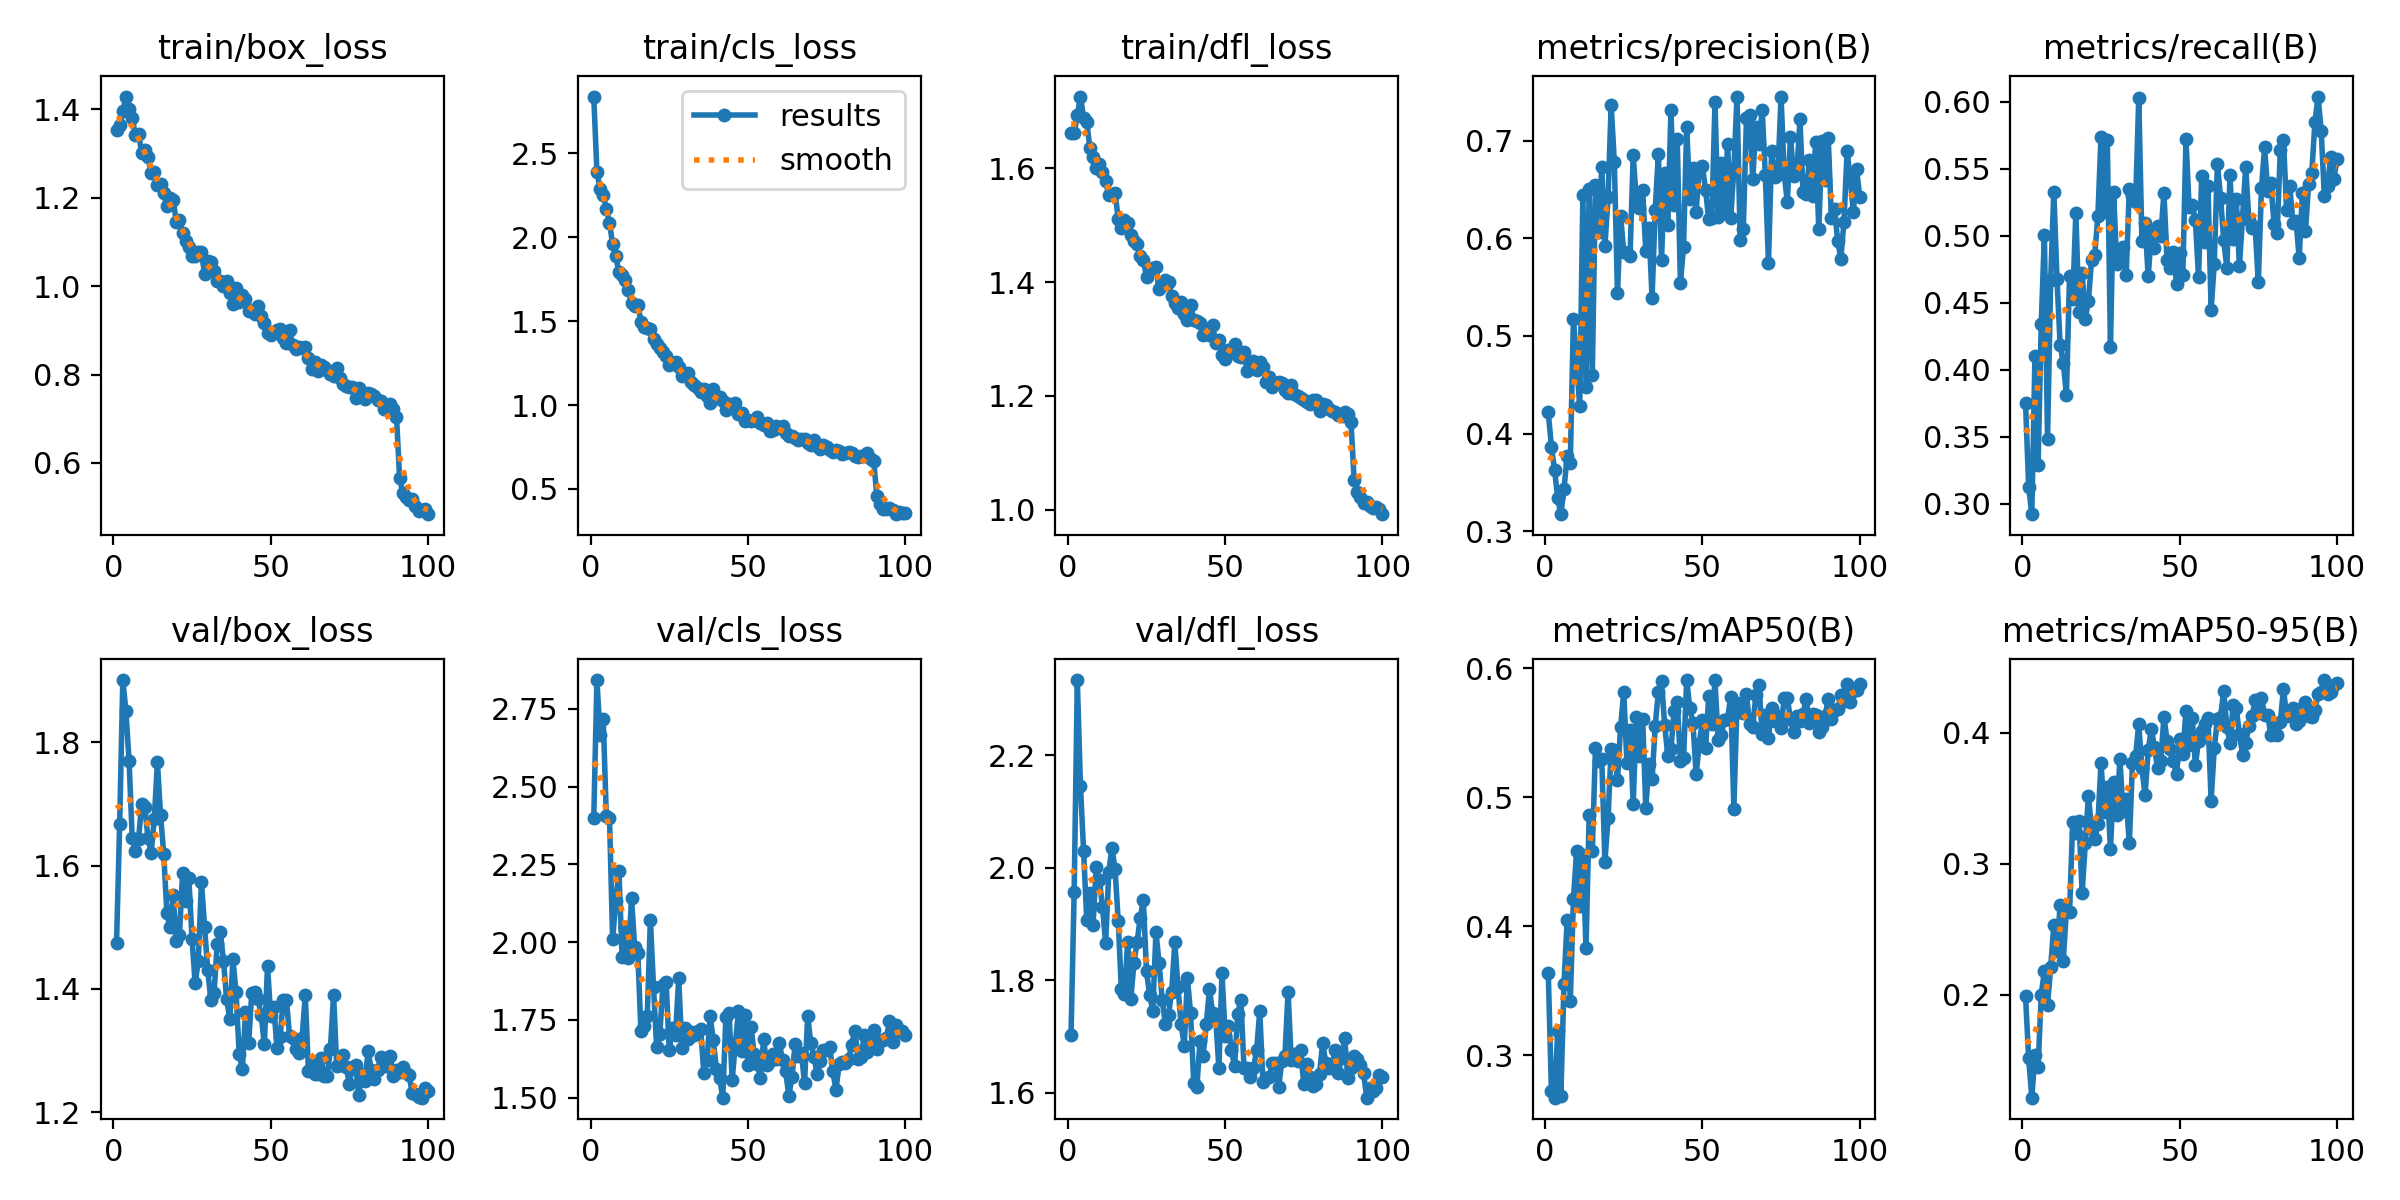


🧩 Confusion Matrix:


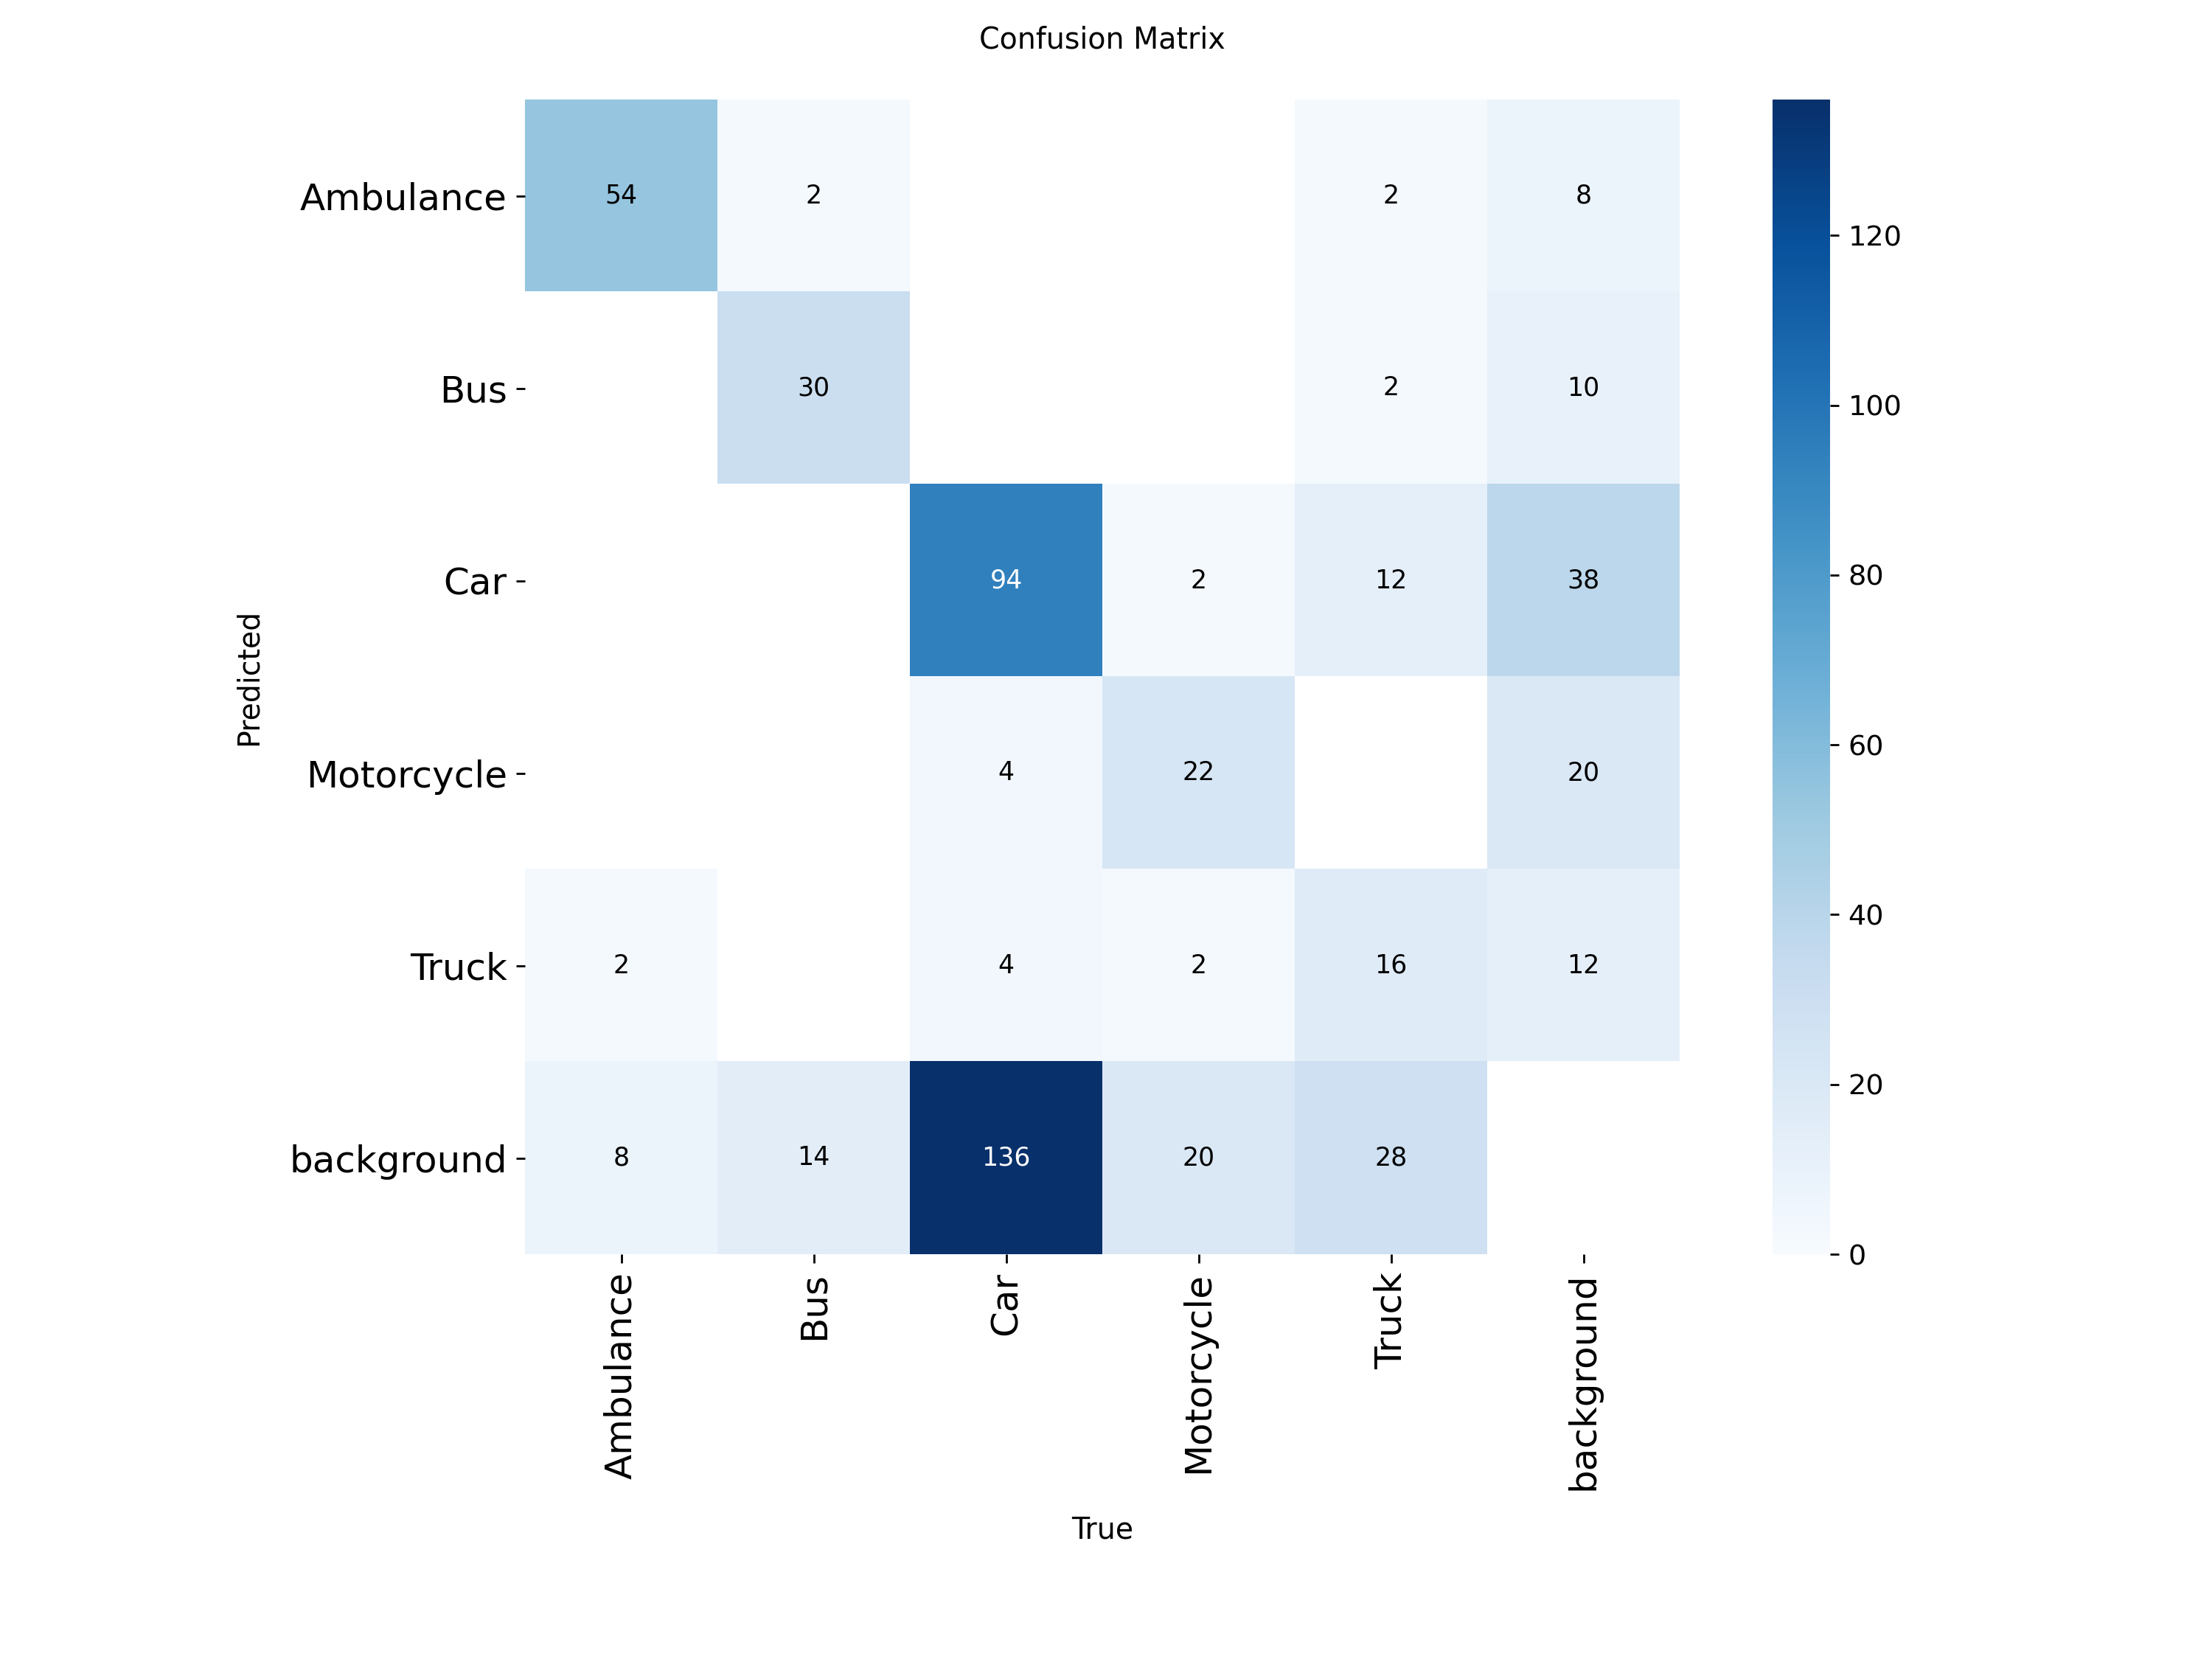

In [ ]:
from IPython.display import Image, display
import os

# Define result directory
result_dir = '/kaggle/working/training_results/yolov8n_augmented'

# Display Training Curves
print("📈 Training Results (Loss & Accuracy):")
display(Image(filename=f'{result_dir}/results.png'))

# Display Confusion Matrix
print("\n🧩 Confusion Matrix:")
if os.path.exists(f'{result_dir}/confusion_matrix.png'):
    display(Image(filename=f'{result_dir}/confusion_matrix.png'))

Testing: a3cffcdbff959432_jpg.rf.1f1f8cfcdfe052a8ec72e63b11889b66.jpg

image 1/1 /kaggle/working/yolo_datasetBalanced/images/test/a3cffcdbff959432_jpg.rf.1f1f8cfcdfe052a8ec72e63b11889b66.jpg: 640x640 1 Truck, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/inference/demo


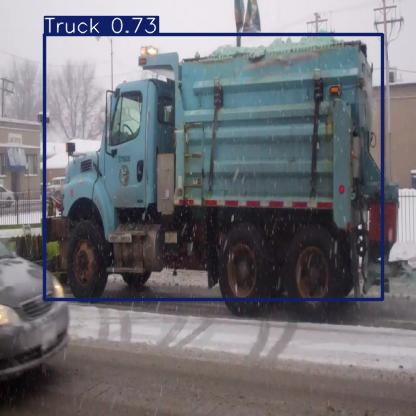

Testing: 8ccad0d567bc7aad_jpg.rf.bbeeab003239f3c9854ed0d97fbc3520.jpg

image 1/1 /kaggle/working/yolo_datasetBalanced/images/test/8ccad0d567bc7aad_jpg.rf.bbeeab003239f3c9854ed0d97fbc3520.jpg: 640x640 4 Cars, 8.1ms
Speed: 4.0ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/inference/demo


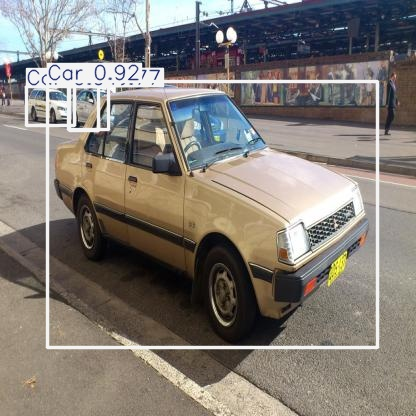

Testing: e4029e591e9568b4_jpg.rf.7d1631ccd8fdcc764c4198e44ad121b4.jpg

image 1/1 /kaggle/working/yolo_datasetBalanced/images/test/e4029e591e9568b4_jpg.rf.7d1631ccd8fdcc764c4198e44ad121b4.jpg: 640x640 1 Car, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/inference/demo


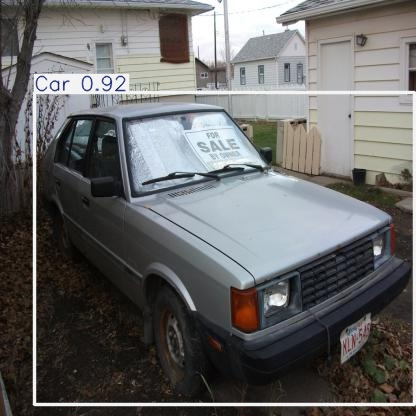

In [ ]:
import glob
import random


# Load the best trained weights
best_model = YOLO(f'{result_dir}/weights/best.pt')

# Select random images from Test set
test_images = glob.glob('/kaggle/working/yolo_datasetBalanced/images/test/*.jpg')
sample_images = random.sample(test_images, 3) if len(test_images) >= 3 else test_images

for img_path in sample_images:
    print(f"Testing: {os.path.basename(img_path)}")

    # Run Inference
    best_model.predict(
        source=img_path,
        imgsz=640,
        conf=0.4, # Confidence threshold
        save=True,
        project='/kaggle/working/inference',
        name='demo',
        exist_ok=True
    )

    # Show Result
    predicted_path = os.path.join('/kaggle/working/inference/demo', os.path.basename(img_path))
    display(Image(filename=predicted_path))